Run the following cell to clear your processed data folders

In [93]:
# !rm -i data_processed/seg_mask_croped/2013/*  -rf
!rm -i data_processed/mnt_croped/2013/*  -rf

# Data processing

## TIF image cropping

The dataset is composed of three datasource, all TIF image:
- the `ortho_YEAR.tif.ovr`: the satellite picture of the river
- the `shape_YEAR_tif`: the segmentation mask of the bed ofpebbles
- the `mnt_relatif_YEAR.tif`: the blablablabla # TODO

The tif being too large (71618 x 32460 pixels) to be handled in an np.array, we
will create subimage by cropping the original TIFs, and removing the subimages
containing no data (filled with -inf pixel value)

In [75]:
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None

In [76]:
from tqdm import tqdm
import numpy as np

def crop_images(tif_file, tif_cat, output_dir, step_width=541, step_height=385, num_splits_width=60, num_splits_height=186):
    for i in tqdm(range(1, num_splits_width + 1)): # width
        for j in range(1, num_splits_height + 1): # height
            crop_coordinate = ((i-1)*step_width, (j-1)*step_height, i*step_width, j*step_height)
            crop = tif_file.crop(crop_coordinate)
            crop_array = np.array(crop)

            if not len(np.unique(crop_array)) == 1: # toutes les valuers dans l'array sont -inf ou -3.4028235e+38
                np.save(f'{output_dir}/{tif_cat}_{crop_coordinate}.npy', crop_array)

### Orthophoto

In [54]:
### TODO extract ortho as TIF file

In [ ]:
ortho = Image.open("2013/ortho_2013.tif")
ortho.load()

UnidentifiedImageError: cannot identify image file '2013/ortho_2013.tif.ovr'

In [ ]:
del ortho

### Segmentation mask

In [64]:
## TODO rajouter des shutil pour supprimer les dossiers avant de régénérer les données

In [77]:
seg_mask = Image.open("data_raw/2013/shape_2013_tif.tif")
seg_mask.load()

assert(seg_mask.height == 71618)
assert(seg_mask.width == 32460)

In [78]:
crop_images(seg_mask, 'seg_mask', 'data_processed/seg_mask_croped/2013')

100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


In [79]:
import os

seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'

seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

print(f'{len(seg_mask_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{seg_mask_crop_dir}/{seg_mask_crop_list[0]}").shape}')

130 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [80]:
del seg_mask

### MNT

In [95]:
mnt = Image.open("data_raw/2013/mnt_relatif.tif")
mnt.load()

##### TODO mettre tous le code de description des caractéristiques des images dans la première section de preprocessing

print(f'Height of the picture: {mnt.height}, width: {mnt.width}')
assert(mnt.height == 71618)
assert(mnt.width == 32460)

print(f'Width of croped img: {32460/60}')
step_width = int(mnt.width/60)

print(f'Height of croped img (removing 8 pixels to be able to divide it with int): {(71618-8)/186}')
setp_height = int((mnt.height-8)/186)

Height of the picture: 71618, width: 32460
Width of croped img: 541.0
Height of croped img (removing 8 pixels to be able to divide it with int): 385.0


In [96]:
crop_images(mnt, 'mnt', 'data_processed/mnt_croped/2013')

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:09<00:00,  6.15it/s]


In [97]:
import os
import numpy as np

mnt_crop_dir = 'data_processed/mnt_croped/2013'

mnt_crop_list = os.listdir(mnt_crop_dir)

print(f'{len(mnt_crop_list)} images cropées conservées sur {60*186} générées')
print(f'Les images cropées ont la shape suivante : {np.load(f"{mnt_crop_dir}/{mnt_crop_list[0]}").shape}')

523 images cropées conservées sur 11160 générées
Les images cropées ont la shape suivante : (385, 541)


In [98]:
del mnt

### Creation of missing segmask

Only 130 out of the 523 needed segmasks were creating via cropping, as most of 
the ortho and mnt crops don't have peebles bed on it. Thus, we will create the 
missing segmasks, filled with 0.

In [81]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)

crop_shape = (385, 541)

for mnt in mnt_crop_list:
    crop_coordinate = mnt.split('_')[-1].split('.')[0]

    seg_mask_exist = False

    for seg_mask in seg_mask_crop_list:
        if crop_coordinate in seg_mask:
            seg_mask_exist = True
            break

    if not seg_mask_exist:
        seg_mask = np.zeros(crop_shape)
        np.save(f'{seg_mask_crop_dir}/seg_mask_{crop_coordinate}.npy', seg_mask)


Let's check that we have the same number of crops and at the same coordinates

In [82]:
seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)
seg_mask_crop_list.sort()

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)
mnt_crop_list.sort()

assert len(mnt_crop_list) == len(seg_mask_crop_list)

for seg_mask, mnt in zip(seg_mask_crop_list, mnt_crop_list):
    seg_mask_coord = seg_mask.split('_')[-1].split('.')[0]
    mnt_coord = mnt.split('_')[-1].split('.')[0]

    assert seg_mask_coord == mnt_coord

### Checking data type

#### Seg masks

In [83]:
import pandas as pd

seg_mask_dict = {}

for seg_mask in seg_mask_crop_list:
    unique_ids = np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask}'))
    if len(unique_ids) in seg_mask_dict.keys():
        seg_mask_dict[len(unique_ids)] += 1
    else:
        seg_mask_dict.update({len(unique_ids): 1})

In [84]:
df = pd.DataFrame.from_dict(seg_mask_dict, orient='index').reset_index()
df.columns = ["number_of_peebles_bed", "number_of_croped_seg_mask"]
df['number_of_peebles_bed'] -= 1
df.sort_values(by='number_of_croped_seg_mask', ascending=False)

,number_of_peebles_bed,number_of_croped_seg_mask
1,0,393
0,1,85
2,2,35
3,3,8
4,4,2


The vast majority of segmask don't have any peebles - this a point to keep in mind during training.

Let's check the array of the some segmentation masks

In [85]:
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')))

[ 0 76 77]
[ 0 73]
[ 0 94]
[0.]


in the instance annotation masks, the R(ed) channel encodes category ID, and the G(reen) channel encodes instance ID. Each object instance has a unique instance ID regardless of its category ID.
So we should :
- create a new channel to encode category ID, that will be our first channel (Red)
- pass the actual ids into the second channel (Green)
- create a third channel full of 0 (Blue)

In [86]:
import os
import numpy as np

for seg_mask in seg_mask_crop_list:
    G_channel = np.load(f'{seg_mask_crop_dir}/{seg_mask}')
    R_channel = np.where(G_channel > 0, 1, G_channel)
    B_channel = np.zeros_like(G_channel)

    three_channel_arr = np.array([R_channel, G_channel, B_channel])

    np.save(f'{seg_mask_crop_dir}/{seg_mask}', three_channel_arr)

In [92]:
print('############')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[7]}')[2]))
print('############')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[25]}')[2]))
print('###########')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[291]}')[2]))
print('###########')
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')[0]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')[1]))
print(np.unique(np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[450]}')[2]))
print('###########')

############
[0 1]
[ 0 76 77]
[0]
############
[0 1]
[ 0 73]
[0]
###########
[0 1]
[ 0 94]
[0]
###########
[0.]
[0.]
[0.]
###########


We have now the category ID on our first channel (Red), the instance ID in the second channel (Green) and nothing on the third one (Blue).

#### Mnt

Let's laod a croped mnt

In [103]:
mnt = np.load(f'{mnt_crop_dir}/{mnt_crop_list[0]}')

np.min(np.unique(mnt))

np.float32(-3.4028235e+38)

In [105]:
mnt.shape

(385, 541)

In [101]:
real_min = 0

for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_min = np.min(mnt_arr[mnt_arr > -1e6])
    if mnt_min < real_min:
        real_min = mnt_min

real_min

np.float32(-4.151123)

There is some `-inf` value where the mnt was not calculated. The real min is `-4.15`. We will replace these `-inf` values by `np.nan`. Also, these files have only one channel, our the model inputs has to have 3 channels, we will thus expand our array dims.

In [112]:
for mnt in mnt_crop_list:
    mnt_arr = np.load(f'{mnt_crop_dir}/{mnt}')
    mnt_arr = np.where(mnt_arr < -10, np.nan, mnt_arr)
    mnt_arr = np.array([mnt_arr]*3)
    np.save(f'{mnt_crop_dir}/{mnt}', mnt_arr)

## Visualisation

In [ ]:
#### TODO savoir cb j'ai de lit de caillou segmenté au total

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

seg_mask_crop_dir = 'data_processed/seg_mask_croped/2013'
seg_mask_crop_list = os.listdir(seg_mask_crop_dir)

mnt_crop_dir = 'data_processed/mnt_croped/2013'
mnt_crop_list = os.listdir(mnt_crop_dir)

seg_mask_crop_list.sort()
mnt_crop_list.sort()

id_of_crops_with_pebble_bed = []

for idx, label in enumerate(seg_mask_crop_list):
  label_arr = np.load(f'{seg_mask_crop_dir}/{label}')
  if np.sum(label_arr) > 0:
    id_of_crops_with_pebble_bed.append(idx)

len(id_of_crops_with_pebble_bed)

130

In [4]:
def rescale_instance_id(G_channel):
    num_instance = len(np.unique(G_channel))
    colors = np.uint8(np.linspace(0, 255, num_instance))[1:]
    return colors

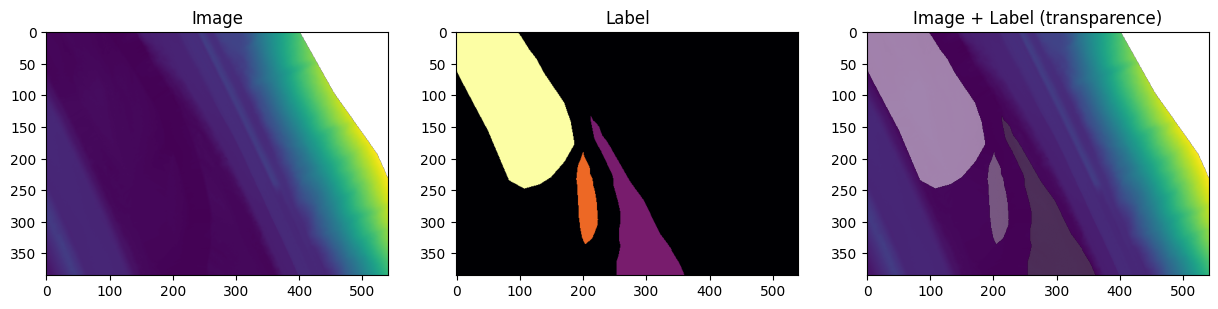

In [10]:
import matplotlib.cm as cm

idx = id_of_crops_with_pebble_bed[16]

seg_mask = np.load(f'{seg_mask_crop_dir}/{seg_mask_crop_list[idx]}')
mnt = np.load(f'{mnt_crop_dir}/{mnt_crop_list[idx]}')

seg_mask_R_channel = seg_mask[0]
seg_mask_G_channel = seg_mask[1]

colors = rescale_instance_id(seg_mask_G_channel)

for color, id in zip(colors, np.unique(seg_mask_G_channel)[1:]):
    seg_mask_G_channel = np.where(seg_mask_G_channel == id, color, seg_mask_G_channel)

f, axarr = plt.subplots(1,3)
f.set_figheight(15)
f.set_figwidth(15)

axarr[0].imshow(mnt[0])
axarr[0].set_title("Image")

axarr[1].imshow(seg_mask_G_channel, cmap='inferno')
axarr[1].set_title("Label")

mask = seg_mask_G_channel != 0

axarr[2].imshow(mnt[0])
axarr[2].imshow(np.ma.masked_where(~mask, seg_mask_G_channel),
                cmap=cm.gray, alpha=0.5, vmin=0, vmax=255)
axarr[2].set_title("Image + Label (transparence)");

In [17]:
highest_bed_id = 0

for seg_mask in seg_mask_crop_list:
    mask = np.load(f'{seg_mask_crop_dir}/{seg_mask}')
    mask_G_channel = mask[1]
    max_id = np.max(mask_G_channel)
    if max_id > highest_bed_id:
        highest_bed_id = max_id

highest_bed_id

np.uint8(160)

In all our data, 160 pebble beds were labeled, and are present across 130 croped images.